In [1]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.4 MB/s eta 0:00:00


In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructType, IntegerType, DateType, StructField, FloatType
import pyspark.sql.functions as f

from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

import pandas as pd

In [7]:
data_path = '/content/electronic_devices.csv'

In [8]:
data = pd.read_csv(data_path)
data

,customer_id,age,gender,loyalty_member,product_type,sku,rating,order_status,payment_method,total_price,unit_price,quantity,purchase_date,shipping_type,addons,addons_cnt
0,1000,53,Male,No,Smartphone,SKU1004,2,Cancelled,Credit Card,5538.33,791.19,7,2024-03-20,Standard,"Accessory,Accessory,Accessory",40.21
1,1000,53,Male,No,Tablet,SKU1002,3,Completed,Paypal,741.09,247.03,3,2024-04-20,Overnight,Impulse Item,26.09
2,1002,41,Male,No,Laptop,SKU1005,3,Completed,Credit Card,1855.84,463.96,4,2023-10-17,Express,NaN,0.00
3,1002,41,Male,Yes,Smartphone,SKU1004,2,Completed,Cash,3164.76,791.19,4,2024-08-09,Overnight,"Impulse Item,Impulse Item",60.16
4,1003,75,Male,Yes,Smartphone,SKU1001,5,Completed,Cash,41.50,20.75,2,2024-05-21,Express,Accessory,35.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,27,Female,No,Smartphone,SMP234,4,Completed,Bank Transfer,6838.08,1139.68,6,2024-06-15,Expedited,NaN,0.00
19996,19996,27,Female,Yes,Laptop,LTP123,4,Cancelled,Credit Card,2697.28,674.32,4,2024-07-18,Standard,NaN,0.00
19997,19996,27,Female,No,Headphones,HDP456,4,Completed,Bank Transfer,1805.90,361.18,5,2024-08-26,Standard,"Impulse Item, Extended Warranty, Accessory",198.98
19998,19997,27,Male,No,Headphones,HDP456,1,Cancelled,Bank Transfer,2528.26,361.18,7,2024-01-06,Expedited,"Extended Warranty, Accessory",101.34


In [19]:
data = pd.read_csv(data_path)
metadata = Metadata.detect_from_dataframe(
    data=data,
    table_name='electronic_devices'
)
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(data=data)

/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


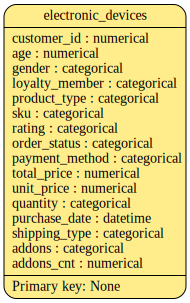

In [10]:
metadata.visualize()

In [11]:
synth_data = synthesizer.sample(num_rows=1000000)

In [12]:
type(synth_data)

pandas.core.frame.DataFrame

In [13]:
synth_data.shape

(1000000, 16)

In [12]:
synth_data.to_csv('synth_electronic_devices.csv')

In [15]:
quality_report = evaluate_quality(
    data,
    synth_data,
    metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 16/16 [00:02<00:00,  5.40it/s]|
Column Shapes Score: 94.43%

(2/2) Evaluating Column Pair Trends: |██████████| 120/120 [00:32<00:00,  3.68it/s]|
Column Pair Trends Score: 83.39%

Overall Score (Average): 88.91%



In [26]:
spark = SparkSession \
            .builder \
            .appName("electronic_devices") \
            .master("local") \
            .getOrCreate()

In [27]:
df = spark \
    .read \
    .option("header", "true") \
    .option("multiline", "true") \
    .option("sep", ",") \
    .option("quote", "*") \
    .option("dateFormat", "M/d/y") \
    .option("inferSchema", "true") \
    .csv(data_path)

In [28]:
df.show(10,20)

+-----------+---+------+--------------+------------+-------+------+------------+--------------+-----------+----------+--------+-------------------+-------------+------------------+------------------+
|customer_id|age|gender|loyalty_member|product_type|    sku|rating|order_status|payment_method|total_price|unit_price|quantity|      purchase_date|shipping_type|            addons|        addons_cnt|
+-----------+---+------+--------------+------------+-------+------+------------+--------------+-----------+----------+--------+-------------------+-------------+------------------+------------------+
|       1000| 53|  Male|            No|  Smartphone|SKU1004|     2|   Cancelled|   Credit Card|    5538.33|    791.19|       7|2024-03-20 00:00:00|     Standard|        "Accessory|         Accessory|
|       1000| 53|  Male|            No|      Tablet|SKU1002|     3|   Completed|        Paypal|     741.09|    247.03|       3|2024-04-20 00:00:00|    Overnight|      Impulse Item|             26.09|


In [29]:
df.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- loyalty_member: string (nullable = true)
 |-- product_type: string (nullable = true)
 |-- sku: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- order_status: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- total_price: double (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- purchase_date: timestamp (nullable = true)
 |-- shipping_type: string (nullable = true)
 |-- addons: string (nullable = true)
 |-- addons_cnt: string (nullable = true)



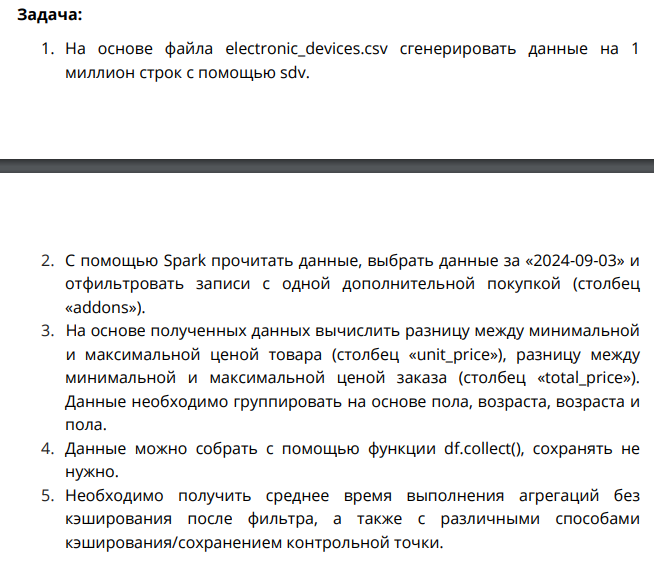

In [41]:
sub_df = df.filter(f.col("purchase_date") == f.unix_timestamp(f.lit('2024-09-03 00:00:00')).cast('timestamp'))
sub_df.show(5,20)

+-----------+---+------+--------------+------------+-------+------+------------+--------------+-----------+----------+--------+-------------------+-------------+------------------+-------------+
|customer_id|age|gender|loyalty_member|product_type|    sku|rating|order_status|payment_method|total_price|unit_price|quantity|      purchase_date|shipping_type|            addons|   addons_cnt|
+-----------+---+------+--------------+------------+-------+------+------------+--------------+-----------+----------+--------+-------------------+-------------+------------------+-------------+
|       1031| 20|Female|            No|  Smartphone|SKU1001|     5|   Completed|    Debit Card|     103.75|     20.75|       5|2024-09-03 00:00:00|    Overnight|        "Accessory|   Accessory"|
|       2513| 40|Female|            No|  Smartphone|SKU1004|     2|   Completed|          Cash|    5538.33|    791.19|       7|2024-09-03 00:00:00|     Standard|        "Accessory| Impulse Item|
|       2607| 68|  Male| 

In [63]:
%%timeit
sub_df.groupby('gender')\
      .agg(f.max('total_price').alias('max_tp'),
           f.min('total_price').alias('min_tp'),
           f.max('unit_price').alias('max_up'),
           f.min('unit_price').alias('min_up'))\
      .withColumn('diff_total_price', f.column('max_tp') - f.column('min_tp'))\
      .withColumn('diff_unit_price', f.column('max_up') - f.column('min_up'))\
      .show()

+------+--------+------+-------+------+----------------+---------------+
|gender|  max_tp|min_tp| max_up|min_up|diff_total_price|diff_unit_price|
+------+--------+------+-------+------+----------------+---------------+
|Female|10257.12|103.75|1139.68| 20.75|        10153.37|        1118.93|
|  Male| 11396.8|  41.5|1139.68| 20.75|         11355.3|        1118.93|
+------+--------+------+-------+------+----------------+---------------+

+------+--------+------+-------+------+----------------+---------------+
|gender|  max_tp|min_tp| max_up|min_up|diff_total_price|diff_unit_price|
+------+--------+------+-------+------+----------------+---------------+
|Female|10257.12|103.75|1139.68| 20.75|        10153.37|        1118.93|
|  Male| 11396.8|  41.5|1139.68| 20.75|         11355.3|        1118.93|
+------+--------+------+-------+------+----------------+---------------+

+------+--------+------+-------+------+----------------+---------------+
|gender|  max_tp|min_tp| max_up|min_up|diff_total

In [65]:
%%timeit
sub_df.groupby('gender')\
      .agg(f.max('total_price').alias('max_tp'),
           f.min('total_price').alias('min_tp'),
           f.max('unit_price').alias('max_up'),
           f.min('unit_price').alias('min_up'))\
      .withColumn('diff_total_price', f.column('max_tp') - f.column('min_tp'))\
      .withColumn('diff_unit_price', f.column('max_up') - f.column('min_up'))

75.1 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
gb_gender = round(1010/75,3)
gb_gender

13.467

In [66]:
%%timeit
sub_df.groupby('age')\
      .agg(f.max('total_price').alias('max_tp'),
           f.min('total_price').alias('min_tp'),
           f.max('unit_price').alias('max_up'),
           f.min('unit_price').alias('min_up'))\
      .withColumn('diff_total_price', f.column('max_tp') - f.column('min_tp'))\
      .withColumn('diff_unit_price', f.column('max_up') - f.column('min_up'))\
      .sort(['age'])\
      .show()

+---+-------+-------+-------+------+------------------+------------------+
|age| max_tp| min_tp| max_up|min_up|  diff_total_price|   diff_unit_price|
+---+-------+-------+-------+------+------------------+------------------+
| 19| 3611.8| 786.41| 786.41|361.18|2825.3900000000003|425.22999999999996|
| 20| 103.75| 103.75|  20.75| 20.75|               0.0|               0.0|
| 21|2167.08|2167.08| 361.18|361.18|               0.0|               0.0|
| 22|9117.44|   41.5|1139.68| 20.75|           9075.94|           1118.93|
| 23|  124.5|  124.5|  20.75| 20.75|               0.0|               0.0|
| 26|1139.68|  919.0|1139.68| 459.5|220.68000000000006| 680.1800000000001|
| 27|4718.46|1855.84| 786.41|463.96|           2862.62|            322.45|
| 28| 5698.4| 3676.0|1139.68| 459.5|2022.3999999999996| 680.1800000000001|
| 29|5068.98|1482.18| 844.83|247.03|3586.7999999999993| 597.8000000000001|
| 31|6068.88|2528.26| 674.32|361.18|           3540.62|313.14000000000004|
| 32|4175.64|4175.64| 463

In [68]:
%%timeit
sub_df.groupby('age')\
      .agg(f.max('total_price').alias('max_tp'),
           f.min('total_price').alias('min_tp'),
           f.max('unit_price').alias('max_up'),
           f.min('unit_price').alias('min_up'))\
      .withColumn('diff_total_price', f.column('max_tp') - f.column('min_tp'))\
      .withColumn('diff_unit_price', f.column('max_up') - f.column('min_up'))\
      .sort(['age'])

193 ms ± 45.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
gb_age = round(1100/193,3)
gb_age

5.699

In [69]:
%%timeit
sub_df.groupby(['gender', 'age'])\
      .agg(f.max('total_price').alias('max_tp'),
           f.min('total_price').alias('min_tp'),
           f.max('unit_price').alias('max_up'),
           f.min('unit_price').alias('min_up'))\
      .withColumn('diff_total_price', f.column('max_tp') - f.column('min_tp'))\
      .withColumn('diff_unit_price', f.column('max_up') - f.column('min_up'))\
      .sort(['age', 'gender'])\
      .show()

+------+---+-------+-------+-------+-------+------------------+------------------+
|gender|age| max_tp| min_tp| max_up| min_up|  diff_total_price|   diff_unit_price|
+------+---+-------+-------+-------+-------+------------------+------------------+
|Female| 19| 3611.8| 786.41| 786.41| 361.18|2825.3900000000003|425.22999999999996|
|  Male| 19|1348.64|1348.64| 674.32| 674.32|               0.0|               0.0|
|Female| 20| 103.75| 103.75|  20.75|  20.75|               0.0|               0.0|
|Female| 21|2167.08|2167.08| 361.18| 361.18|               0.0|               0.0|
|Female| 22| 2470.3| 2470.3| 247.03| 247.03|               0.0|               0.0|
|  Male| 22|9117.44|   41.5|1139.68|  20.75|           9075.94|           1118.93|
|Female| 23|  124.5|  124.5|  20.75|  20.75|               0.0|               0.0|
|Female| 26|  919.0|  919.0|  459.5|  459.5|               0.0|               0.0|
|  Male| 26|1139.68|1139.68|1139.68|1139.68|               0.0|               0.0|
|Fem

In [70]:
%%timeit
sub_df.groupby(['gender', 'age'])\
      .agg(f.max('total_price').alias('max_tp'),
           f.min('total_price').alias('min_tp'),
           f.max('unit_price').alias('max_up'),
           f.min('unit_price').alias('min_up'))\
      .withColumn('diff_total_price', f.column('max_tp') - f.column('min_tp'))\
      .withColumn('diff_unit_price', f.column('max_up') - f.column('min_up'))\
      .sort(['age', 'gender'])

94.4 ms ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
gb_age_gender = round(913/94,3)

In [87]:
sum([gb_age, gb_gender, gb_age_gender])/3

9.626333333333333

Без кеширование, как и ожидалось расчеты происходят быстрее, в среднем в 9.6 раз